# **# Importing the necessary libraries**

In [1]:
import pandas as pd        
import numpy as np        
import matplotlib.pyplot as plt  
import seaborn as sns      
from sklearn.feature_extraction.text import TfidfVectorizer  # for text vectorization 
from sklearn.metrics.pairwise import cosine_similarity # for similarity calculations
import ast  #for parsing
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import accuracy

In [2]:
# Ignore warnings to keep the output clean
import warnings
warnings.filterwarnings('ignore')

# exploring the dataset

In [3]:
import os

# list all files 
print(os.listdir('/kaggle/input/the-movies-dataset'))


['ratings.csv', 'links_small.csv', 'credits.csv', 'keywords.csv', 'movies_metadata.csv', 'ratings_small.csv', 'links.csv']


In [4]:
# load the movie metadata dataset
movies_df = pd.read_csv('/kaggle/input/the-movies-dataset/movies_metadata.csv', low_memory=False)

# display the first few rows of the dataset
print("Movies Metadata - First 5 rows:")
movies_df.head()


Movies Metadata - First 5 rows:


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [5]:
# check the shape of the dataset
print("\nMovies Metadata shape:", movies_df.shape)

# display the column names to see what data is available
print("\nColumns in Movies Metadata:")
movies_df.columns


Movies Metadata shape: (45466, 24)

Columns in Movies Metadata:


Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

# selecting & cleaning relevant columns

In [6]:
#since this is a content_based recommender system only choose "title","genres","overview"
movies_df = movies_df[['title', 'genres', 'overview']]

# drop rows where the title is missing
movies_df = movies_df.dropna(subset=['title'])

# reset index after dropping rows
movies_df = movies_df.reset_index(drop=True)

# fill missing values with an empty string 
movies_df['overview'] = movies_df['overview'].fillna('')


In [7]:
# check the data types of the columns
print("\nData Types:")
print(movies_df.dtypes)

# check for any remaining missing values
print("\nMissing Values:")
print(movies_df.isnull().sum())

# display the first few rows of the cleaned dataset
print("Cleaned Data - First 5 rows:")
movies_df.head()


Data Types:
title       object
genres      object
overview    object
dtype: object

Missing Values:
title       0
genres      0
overview    0
dtype: int64
Cleaned Data - First 5 rows:


,title,genres,overview
0,Toy Story,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...","Led by Woody, Andy's toys live happily in his ..."
1,Jumanji,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",When siblings Judy and Peter discover an encha...
2,Grumpier Old Men,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",A family wedding reignites the ancient feud be...
3,Waiting to Exhale,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...","Cheated on, mistreated and stepped on, the wom..."
4,Father of the Bride Part II,"[{'id': 35, 'name': 'Comedy'}]",Just when George Banks has recovered from his ...


# building the recommender system

# 1. feature extraction
limit the maximum number of features in the TF-IDF vectorizer to reduce matrix size:



In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

# create a TF-IDF Vectorizer for the 'overview' column
tfidf = TfidfVectorizer(stop_words='english')

# fit and transform the overview data into a TF-IDF matrix
tfidf_matrix = tfidf.fit_transform(movies_df['overview'])

# check the shape of the resulting matrix
print("TF-IDF Matrix shape:", tfidf_matrix.shape)

TF-IDF Matrix shape: (45460, 75827)


# 2. compute cosine similarity

In [9]:
from sklearn.metrics.pairwise import cosine_similarity

# compute the cosine similarity matrix from the TF-IDF matrix
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# check the shape of the similarity matrix
print("Cosine Similarity Matrix shape:", cosine_sim.shape)


Cosine Similarity Matrix shape: (45460, 45460)


# 3. build the recommendation function

In [10]:
# create a mapping of movie titles to indices insuring there is no dupliactes
indices = pd.Series(movies_df.index, index=movies_df['title']).drop_duplicates()

In [11]:
def recommend_movies(title, cosine_sim=cosine_sim):
    # get the index of the movie that matches the title
    idx = indices[title]
    
    # get the pairwise similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    # sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]  # Exclude the first one as it is the movie itself
    
    # get the movie indices
    movie_indices = [i[0] for i in sim_scores]
    
    # return the top 10 most similar movies
    return movies_df['title'].iloc[movie_indices]



In [12]:
# example: recommend movies similar to "Jumanji"
print("top 10 most similar movies to Jumanji based on content:")
recommend_movies('Jumanji')

top 10 most similar movies to Jumanji based on content:


21631         Table No. 21
45247                 Quiz
41567         Snowed Under
35505             The Mend
44370    Liar Game: Reborn
17223       The Dark Angel
8801               Quintet
6166             Brainscan
30977         Turkey Shoot
9503             Word Wars
Name: title, dtype: object

# further enhance the system by building a hybrid recommender

# 1.  Add Collaborative Filtering

In [13]:
# Load ratings data into a pandas DataFrame
ratings_df = pd.read_csv('/kaggle/input/the-movies-dataset/ratings_small.csv')

# display the first few rows of the ratings dataset
print("Ratings Dataset - First 5 rows:")
ratings_df.head()

Ratings Dataset - First 5 rows:


,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [14]:
# check the shape of the dataset
print("\nRatings Dataset shape:", ratings_df.shape)

# check the column names
print("\nColumns in Ratings Dataset:")
ratings_df.columns


Ratings Dataset shape: (100004, 4)

Columns in Ratings Dataset:


Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')


Missing Values in Ratings Dataset:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

Data Types in Ratings Dataset:
userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object

Number of duplicate rows in Ratings Dataset: 0

Rating Distribution:


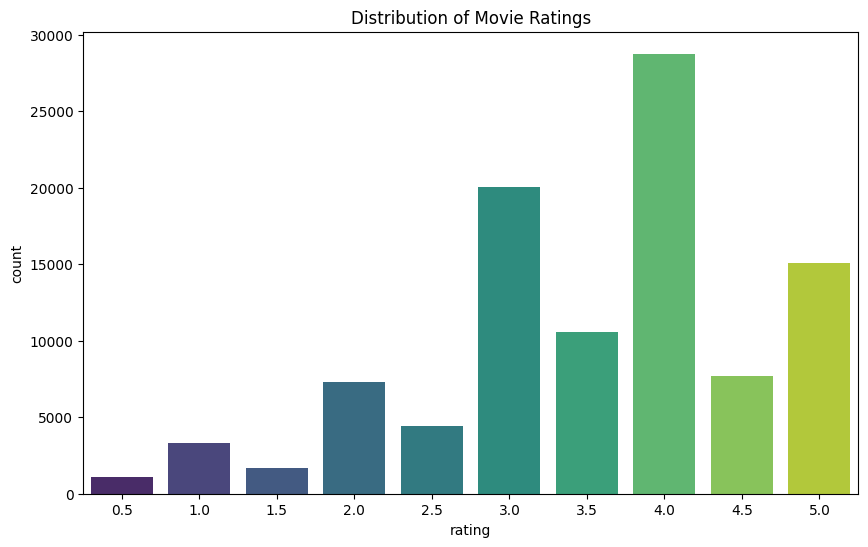

In [15]:
# check for missing values
print("\nMissing Values in Ratings Dataset:")
print(ratings_df.isnull().sum())

# check the data types
print("\nData Types in Ratings Dataset:")
print(ratings_df.dtypes)

# check for duplicate rows
duplicates = ratings_df.duplicated().sum()
print("\nNumber of duplicate rows in Ratings Dataset:", duplicates)

# explore the rating distribution
print("\nRating Distribution:")
ratings_df['rating'].value_counts().sort_index(ascending=False)

# plot the distribution of ratings
plt.figure(figsize=(10, 6))
sns.countplot(x='rating', data=ratings_df, palette='viridis')
plt.title('Distribution of Movie Ratings')
plt.show()


**after exploring the ratings data ,We'll start by implementing collaborative filtering using Singular Value Decomposition (SVD) from the Surprise library. This algorithm factors the user-item interaction matrix to predict missing ratings.**

In [16]:
# define a reader to parse the ratings data with rating scale between 0.5 and 5.0
reader = Reader(rating_scale=(0.5, 5.0))

# load the ratings dataset into the Surprise Dataset format
data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)

# train-test split: 80% training, 20% testing
trainset, testset = train_test_split(data, test_size=0.2)

# display the number of ratings in the test set 
print(f"Testset: {len(testset)} ratings")

# counting the number of ratings in the trainset
trainset_ratings_count = sum(1 for _ in trainset.all_ratings())
print(f"Trainset: {trainset_ratings_count} ratings")


Testset: 20001 ratings
Trainset: 80003 ratings


# 2. Train the SVD Model and Evaluate
SVD (Singular Value Decomposition) is a popular and effective method for collaborative filtering in recommendation systems.
We'll train the SVD model on the training set and then test its performance on the test set using RMSE (Root Mean Squared Error).

In [17]:
# initialize the SVD algorithm
algo = SVD()

# train the model on the training set
algo.fit(trainset)

# test the model on the test set
predictions = algo.test(testset)

# evaluate the model using RMSE
rmse = accuracy.rmse(predictions)

print(f"RMSE: {rmse}")

RMSE: 0.8914
RMSE: 0.891435972261337


**An RMSE of 0.89 is a good result, indicating that my SVD-based collaborative filtering model is doing a decent job predicting user ratings!**

# 3. Build the Hybrid Recommender System
Now, let's combine the content-based and collaborative filtering models into a hybrid recommender system

In [18]:
# create a mapping from movie titles to unique IDs
movies_df['movieId'] = range(1, len(movies_df) + 1)
movie_title_to_id = dict(zip(movies_df['title'], movies_df['movieId']))

# also create a reverse mapping from movie IDs to titles
movie_id_to_title = dict(zip(movies_df['movieId'], movies_df['title']))


In [19]:
def hybrid_recommendation(user_id, title, cosine_sim=cosine_sim, alpha=0.5):
    # get content-based recommendations
    content_recs = recommend_movies(title).tolist()  # ensure this is a list of titles
    
    # ensure that collab_recs is initialized as a list of tuples
    collab_recs = []
    for movie_title in content_recs:
        movie_id = movie_title_to_id.get(movie_title)
        if movie_id is not None:
            try:
                # predict the rating using collaborative filtering
                pred = algo.predict(user_id, str(movie_id))
                collab_recs.append((movie_title, pred.est))
            except:
                # if prediction fails, append a default rating
                collab_recs.append((movie_title, 2.5))
        else:
            # if movie_id is not found, append a default rating
            collab_recs.append((movie_title, 2.5))

    # convert content_recs to a list of tuples (movie_title, score)
    content_recs_with_scores = [(movie_title, 1.0) for movie_title in content_recs]  # Assume content score is 1.0 for now
    
    # combine content-based and collaborative filtering scores using a weighted average
    hybrid_recs = []
    for movie in content_recs:
        # get content score
        content_score = next((score for m, score in content_recs_with_scores if m == movie), 0)
        
        # get collaborative score
        collab_score = next((score for m, score in collab_recs if m == movie), 2.5)  # Default rating if not found
        
        # compute combined score
        combined_score = alpha * content_score + (1 - alpha) * collab_score
        hybrid_recs.append((movie, combined_score))
    
    # sort the recommendations based on the combined scores
    hybrid_recs = sorted(hybrid_recs, key=lambda x: x[1], reverse=True)
    
    # return the top 10 hybrid recommendations
    return [movie for movie, score in hybrid_recs[:10]]


**test the recommender system**

In [20]:
# define a valid user ID and movie title
user_id = 1  
movie_title = 'The Godfather'  

# get the top 10 hybrid recommendations
recommended_movies = hybrid_recommendation(user_id, movie_title)

# print the recommendations
print(f"Top 10 movie recommendations for User {user_id} based on '{movie_title}':")
for movie in recommended_movies:
    print(movie)


Top 10 movie recommendations for User 1 based on 'The Godfather':
The Godfather: Part II
The Godfather Trilogy: 1972-1990
The Godfather: Part III
Blood Ties
Household Saints
Start Liquidation
Election
A Mother Should Be Loved
Short Sharp Shock
Beck 28 - Familjen
